# Flatiron School Data Science Capstone: Automating the Kansas City Freight Industry
## A Lesson in Machine Learning from Experimentation to Product
---
- Presented by Kevin McPherson
- Date Submitted: July 23, 2020
- Date Presented: July 24, 2020
- Cohort Instructor: Jeff Herman 
---

![The freight industry](https://images.tech.co/wp-content/uploads/2018/08/30083911/Future-of-Trucking-Industry-Automated-Technology-VR.jpg)

## Table of Contents

1. [Overview](#Overview)
2. [Abstract](#Abstract)
3. [The OSEMN Framework](#TheOSEMNFramework)
   <br>3.1 [Step 1: Obtain the Data](#obtain)
   <br>3.2 [Step 2: Scrub the Data](#scrub)
   <br>3.3 [Step 3: Explore the Data](#explore)
   <br>3.4 [Step 4: Model the Data](#model)
   <br>3.5 [Step 5: Interpret the Model](#interpret)
4. [Conclusions](#conclu)
5. [Future Work](#future)

## Overview
<a id="Overview"></a>
This project seeks to take a seemingly difficult problem for many of the freight and freight-adjacent companies in the Kansas City area: predict the cost of a car or any other type of vehicle regardless of weather, geographic location of pickup and drop-off, and the characteristics of the payload. Due to the current job market in data science, many employers are searching for data scientists who are more "generalists" than pure data scientists, especially at startups. As such, I have chosen to focus on the machine learning operations (**"MLOps"**) of this project as a main driver for my learning in the capstone project. However, I want to make it known that I also have not abandoned the **OSEMN Framework** that the project entails; it is simply a consequence of my current job that not much time is spent *hypothesizing* so a lot of that work is done ad-hoc, as shown in this notebook. 

---

## Abstract
<a id="Abstract"></a>
Due to it's central location in the United States, Kansas City, Missouri is a prime location for not only distribution centers but the freight car industry. It is estimated that because of its location, 85 percent of the US population could be reached within two days of shipping and freight logistics. It is predicted that between 2016 and 2027, the shipping by truck industry will grow by 27 percent; that's growth from an already staggering 796.7 billion total revenue industry (Statista, 2018). As such, the industry demands a smarter solution to price trips before they happen, so that less operational costs can be spent on coordination of resources (logistics) and more money can be put to the salaries of drivers and truck maintenance for optimal running of the supply chain. Thus, in this capstone project, I will introduce a machine learning model that predicts shipping prices on a smaller attainable market: that of the 12 billion per year vehicle shipping services. My goal is to present both supervised (multiple linear regression), unsupervised (clustering), and ensemble (random forest regressor) learning models and deploy one of them to a requestable API used the FastAPI and Cortex technologies, which have been recently developed, and to deploy a useable model for a company called SuperDispatch which will use this API in their ShipperTMS and CarrierTMS platforms to help merchandisers and freight companies, respectfully. **Numberwise, this will take a trans-geographical, multi-person job and shrink it down into a single click.** 

---

## The OSEMN Framework
<a id="TheOSEMNFramework"></a>

![the OSEMN framework](https://miro.medium.com/max/700/1*eE8DP4biqtaIK3aIy1S2zA.png)

For this project, I will be using the OSEMN Framework. OSEMN stands for **Obtain, Scrub, Explore, Model, and iNterpret**. A more detailed description can be found [here](https://towardsdatascience.com/5-steps-of-a-data-science-project-lifecycle-26c50372b492).

---

<a id="obtain"></a>
# Step 1: *O*btain the Data from Relevant Sources

## Import necessary libraries

In [211]:
import pandas as pd # For data manipulation
import numpy as np # For statistics, file compression
import missingno as msno # For visualization of data completeness
import matplotlib.pyplot as plt
import seaborn as sns
from geopy import distance
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import pickle

## Import the data and assign the columns

In [212]:
# Find the data and import
df = pd.read_csv('/Users/kevinmcpherson/Bellwethr/superdispatch/bellwethr-orders-export-2020-06-24.csv') # Find the data in the right directory

When initially imported, the data does not have the column names. These column names were given to Bellwethr (place I work) by  the clients (SuperDispatch). 
SuperDispatch has an alpha version of their transport predictor, but Bellwethr was recruited to make a new version. As such, we were constrained to a few
features that they wanted as inputs. Namely, `pickup_latitude`, `pickup_longitude`, `delivery_latitude`, `delivery_longitude`, `vehicle_type`, `vehicle_year`, and `is_inoperable`. **I am aware that this is not how traditional data science is done, so I will be adding some additional parts after going through the baseline model.** 

For the API to work with their current system, we were constrained to these features as inputs and having `vehicle_price` as an output. However disappointing this is, it means that there's much room for possible persuasion in the future.

In [213]:
# Assign the columns, as the initial import does not have them
df.columns = ['created_at', 'pickup_address', 'pickup_city',
                 'pickup_state', 'pickup_zip', 'pickup_latitude',
                 'pickup_longitude', 'pickup_date', 'delivery_address',
                 'delivery_city', 'delivery_state', 'delivery_zip',
                 'delivery_latitude', 'delivery_longitude',
                 'delivery_date', 'payment_method', 'price',
                 'inspection_type', 'status', 'vehicle_year', 'vehicle_make', 'vehicle_model',
                 'vehicle_type', 'vehicle_price', 'is_inoperable',
                 'requires_enclosed_trailer']

In [214]:
df.head()

created_at     pickup_address pickup_city pickup_state  \
0  2019-06-01 00:00:39.227653+00            Hwy 131     Wayland           MI   
1  2019-06-01 00:00:39.227653+00            Hwy 131     Wayland           MI   
2  2019-06-01 00:00:39.227653+00            Hwy 131     Wayland           MI   
3  2019-06-01 00:00:59.872031+00  1190 Lancaster Rd     manheim           PA   
4  2019-06-01 00:00:59.872031+00  1190 Lancaster Rd     manheim           PA   

  pickup_zip  pickup_latitude  pickup_longitude pickup_date  \
0      35956        42.674468        -85.661096         NaN   
1      35956        42.674468        -85.661096         NaN   
2      35956        42.674468        -85.661096         NaN   
3      17545        40.139694        -76.396820         NaN   
4      17545        40.139694        -76.396820         NaN   

                delivery_address delivery_city  ...   price inspection_type  \
0               12900 US HWY 431          BOAZ  ...  1500.0             NaN   
1               12900 US HWY 431          BOAZ  ...  1500.0             NaN   
2               12900 US HWY 431          BOAZ  ...  1500.0             NaN   
3  25280 Pleasant Valley Rd #100     chantilly  ...   450.0             NaN   
4  25280 Pleasant Valley Rd #100     chantilly  ...   450.0             NaN   

      status  vehicle_year vehicle_make      vehicle_model   vehicle_type  \
0  delivered        2015.0          GMC        Sierra 1500  4_door_pickup   
1  delivered        2017.0     Chrysler                300          sedan   
2  delivered        2016.0          RAM               1500  4_door_pickup   
3  delivered        2014.0         land  rover range rover            suv   
4  delivered        2011.0     maserati       quattroporte          other   

  vehicle_price is_inoperable  requires_enclosed_trailer  
0           NaN             f                          f  
1           NaN             f                          f  
2           NaN             f                          f  
3           NaN             f                          f  
4           NaN             f                          f  

[5 rows x 26 columns]

In [215]:
# Visualize the data for completeness
msno.matrix(df.sample(250))

### Conclusions from importing the data:
<a id="conclusionsdataimport"></a>

- We want to be looking at `vehicle_price` as our target variable
- Our features (unfortunately, pre-selected) are `pickup_latitude` (float), `pickup_longitude` (float), `delivery_latitude` (float), `delivery_longitude` (float), `vehicle_type` (str), `vehicle_year` (int), and `is_inoperable` (bool)
- SuperDispatch has informed us that the only vehicles they do price prediction on have a value of `delivered` in the `status` column, so this is another constraint we have to adhere to.
- SuperDispatch calculates distance at runtime of their current solution, so we will have to augment the data
---

<a id="scrub"></a>
# Step 2: *S*crub the Data


Taking what we know from above, let's make a baseline model; we will go back later and do some more hypothesis testing and visualizations in case the company wants to take a different route later on.

First, let's get only the delivered cars (constraint `#3` from the [conclusions of the data import](#conclusiondataimport)).

In [216]:
df = df[(df['status'] == 'delivered')]

Great, now the data looks pretty complete! 

In [217]:
df.head()

created_at     pickup_address pickup_city pickup_state  \
0  2019-06-01 00:00:39.227653+00            Hwy 131     Wayland           MI   
1  2019-06-01 00:00:39.227653+00            Hwy 131     Wayland           MI   
2  2019-06-01 00:00:39.227653+00            Hwy 131     Wayland           MI   
3  2019-06-01 00:00:59.872031+00  1190 Lancaster Rd     manheim           PA   
4  2019-06-01 00:00:59.872031+00  1190 Lancaster Rd     manheim           PA   

  pickup_zip  pickup_latitude  pickup_longitude pickup_date  \
0      35956        42.674468        -85.661096         NaN   
1      35956        42.674468        -85.661096         NaN   
2      35956        42.674468        -85.661096         NaN   
3      17545        40.139694        -76.396820         NaN   
4      17545        40.139694        -76.396820         NaN   

                delivery_address delivery_city  ...   price inspection_type  \
0               12900 US HWY 431          BOAZ  ...  1500.0             NaN   
1               12900 US HWY 431          BOAZ  ...  1500.0             NaN   
2               12900 US HWY 431          BOAZ  ...  1500.0             NaN   
3  25280 Pleasant Valley Rd #100     chantilly  ...   450.0             NaN   
4  25280 Pleasant Valley Rd #100     chantilly  ...   450.0             NaN   

      status  vehicle_year vehicle_make      vehicle_model   vehicle_type  \
0  delivered        2015.0          GMC        Sierra 1500  4_door_pickup   
1  delivered        2017.0     Chrysler                300          sedan   
2  delivered        2016.0          RAM               1500  4_door_pickup   
3  delivered        2014.0         land  rover range rover            suv   
4  delivered        2011.0     maserati       quattroporte          other   

  vehicle_price is_inoperable  requires_enclosed_trailer  
0           NaN             f                          f  
1           NaN             f                          f  
2           NaN             f                          f  
3           NaN             f                          f  
4           NaN             f                          f  

[5 rows x 26 columns]

## Choosing the features, label encoding, data parsing and other integrity-checking operations

First, let's select the features that are going to be in our model, with the `vehicle_price` as the target variable.

In [218]:
df = df[['pickup_latitude', 'pickup_longitude', 'delivery_latitude', 'delivery_longitude', 'vehicle_year',
        'vehicle_type', 'is_inoperable', 'vehicle_price']]

Let's check for any NaN off the bat; we want to make sure that these aren't in our most crucial categories like the `latitude` and `longitude` categories, because we need these to augment the data.

In [219]:
df.isna().sum()

pickup_latitude        601479
pickup_longitude       601479
delivery_latitude      600450
delivery_longitude     600450
vehicle_year            20022
vehicle_type                0
is_inoperable               0
vehicle_price         2074807
dtype: int64

Well, drats! A whole lot of the latitude and longitudes, as well as the target variables are NaNs or missing. This isn't great because it automatically pares down our data by main points and could underfit the model. Nonetheless, with our constraints, there's not much else we can do besides just wholesale drop these columns.

In [220]:
df = df.dropna(how = 'any', axis = 0)

In [221]:
df.head()

pickup_latitude  pickup_longitude  delivery_latitude  delivery_longitude  \
35        26.233345        -80.205093          26.687171          -80.182647   
36        26.233345        -80.205093          26.687171          -80.182647   
37        26.233345        -80.205093          26.687171          -80.182647   
38        26.233345        -80.205093          26.687171          -80.182647   
39        26.233345        -80.205093          26.687171          -80.182647   

    vehicle_year vehicle_type is_inoperable  vehicle_price  
35        2013.0          suv             f           70.0  
36        2018.0          suv             f           70.0  
37        2014.0        sedan             f           70.0  
38        2008.0          suv             f           70.0  
39        2016.0          suv             f           70.0

In [222]:
df['vehicle_year'] = df['vehicle_year'].astype('int') # Make sure vehicle year has a type of of integer
df.is_inoperable = df.is_inoperable.eq('f').mul(0) # Change is_inoperable from t or f to 1 or 0

In [223]:
df.head()

pickup_latitude  pickup_longitude  delivery_latitude  delivery_longitude  \
35        26.233345        -80.205093          26.687171          -80.182647   
36        26.233345        -80.205093          26.687171          -80.182647   
37        26.233345        -80.205093          26.687171          -80.182647   
38        26.233345        -80.205093          26.687171          -80.182647   
39        26.233345        -80.205093          26.687171          -80.182647   

    vehicle_year vehicle_type  is_inoperable  vehicle_price  
35          2013          suv              0           70.0  
36          2018          suv              0           70.0  
37          2014        sedan              0           70.0  
38          2008          suv              0           70.0  
39          2016          suv              0           70.0

## Zip coordinates into one column after parsing through valid coordinates

In [224]:
df['pickup_latitude'] = df['pickup_latitude'].astype('float') # Make sure pickup_latitude is float type
df['delivery_latitude'] = df['delivery_latitude'].astype('float') # Same for delivery_latitude...
df['pickup_longitude'] = df['pickup_longitude'].astype('float') # Same for pickup_longitude...
df['delivery_longitude'] = df['delivery_longitude'].astype('float') # Same for delivery_longitude...

In [225]:
# df['pickup_latitude'] = df[(df['pickup_latitude'] > -90) & (df['pickup_latitude'] < 90)]
# df['delivery_latitude'] = df[(df['delivery_latitude'] > -90) & (df['delivery_latitude'] < 90)]
# df['pickup_longitude'] = df[(df['pickup_longitude'] > -180) & (df['pickup_longitude'] < 180)]
# df['delivery_longitude'] = df[(df['delivery_longitude'] > -180) & (df['delivery_longitude'] < 180)]

In [226]:
df['pickup_coordinates'] = list(zip(df.pickup_latitude,df.pickup_longitude)) # Zip into pickup pair of coordinates and put in new series
df['delivery_coordinates'] = list(zip(df.delivery_latitude,df.delivery_longitude)) # Zip into delivery pair of coordinates and put into new series

## Add a distance feature using Geopy's Great Circle calculation

In [227]:
def gets_distance_miles(row):
    try:
        return distance.great_circle(row['pickup_coordinates'], row['delivery_coordinates']).miles
    except: 
        return ('error')

In [228]:
df['distance']= df.apply(gets_distance_miles, axis=1)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/geopy/point.py:405: UserWarning: Latitude normalization has been prohibited in the newer versions of geopy, because the normalized value happened to be on a different pole, which is probably not what was meant. If you pass coordinates as positional args, please make sure that the order is (latitude, longitude) or (y, x) in Cartesian terms.
  return cls(*args)


In [229]:
df.head()

pickup_latitude  pickup_longitude  delivery_latitude  delivery_longitude  \
35        26.233345        -80.205093          26.687171          -80.182647   
36        26.233345        -80.205093          26.687171          -80.182647   
37        26.233345        -80.205093          26.687171          -80.182647   
38        26.233345        -80.205093          26.687171          -80.182647   
39        26.233345        -80.205093          26.687171          -80.182647   

    vehicle_year vehicle_type  is_inoperable  vehicle_price  \
35          2013          suv              0           70.0   
36          2018          suv              0           70.0   
37          2014        sedan              0           70.0   
38          2008          suv              0           70.0   
39          2016          suv              0           70.0   

                   pickup_coordinates       delivery_coordinates distance  
35  (26.233344800000005, -80.2050934)  (26.6871706, -80.1826468)  31.3871  
36  (26.233344800000005, -80.2050934)  (26.6871706, -80.1826468)  31.3871  
37  (26.233344800000005, -80.2050934)  (26.6871706, -80.1826468)  31.3871  
38  (26.233344800000005, -80.2050934)  (26.6871706, -80.1826468)  31.3871  
39  (26.233344800000005, -80.2050934)  (26.6871706, -80.1826468)  31.3871

Now we have our final dataset to make the API. Let's see now if we can do some data visualization for our purposes of presenting them.

---

<a id="explore"></a>
# Step 3: *E*xplore the Data

## Price vs. Distance: a major pricing factor in most shipping companies

If you look at most any car, truck, motorcycle shipping website, they will probably claim something to the effect of "the trip distance is a key factor in determining price". We don't want to overlook this, so let's try and find some cool visualizations to help us see this and maybe help us find patterns

In [230]:
df['distance'].value_counts() # First, let's look at the distance of the trips
df = df[(df['distance'] != 'error')] # Get rid of any 'error' reads from the function
df['distance'] = df['distance'].astype('float') # Now cast as float

Let's actually visualize this so that we have an idea of what our trips look like. 

In [231]:
df = df[(df['distance'] != 'error')]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [232]:
df['log distance'] = np.log(df['distance']) # Make distance a log since it has a huge range

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [233]:
df['log price'] = np.log(df['vehicle_price']) # Do the same for price

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/series.py:856: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [234]:
df = df.replace([np.inf, -np.inf], np.nan)
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=["log distance", "log price"], how="all")

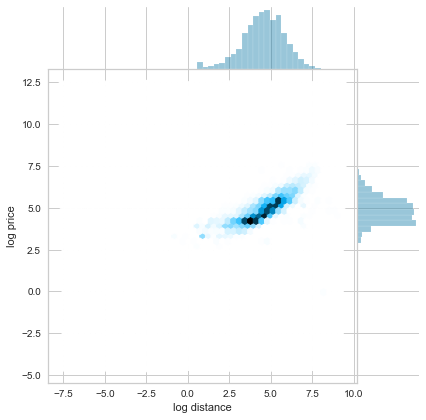

In [235]:
joint_plot = sns.jointplot(x="log distance", y="log price", kind = 'hex', space = 0, data=df)

In [236]:
print('The high density of price range is from', np.exp(1.5), 'to', np.exp(5.0))
print('The high density distance range is from', np.exp(2.6), 'to', np.exp(6))

The high density of price range is from 4.4816890703380645 to 148.4131591025766
The high density distance range is from 13.463738035001692 to 403.4287934927351


In [110]:
joint_plot.savefig("lprice_v_ldist.png") # Save the image

## Type and distance shipped: Is there a difference? 

One interesting proposition pattern to look at would be the vehicle type and if people are shipping certain vehicles longer or shorter distances. Let's take a look at the top 5 of those vehicle types as a shorthand for this analysis.

In [237]:
print('The list of top 5 most shipped vehicle types is', df['vehicle_type'].value_counts()[0:5].index.tolist())

The list of top 5 most shipped vehicle types is ['sedan', 'suv', '4_door_pickup', 'other', 'van']


In [238]:
df['vehicle_type'].unique()

array(['suv', 'sedan', '4_door_pickup', 'other', 'van', 'pickup', 'rv',
       'motorcycle', 'truck_daycab', 'boat', 'heavy_machinery', 'atv',
       'freight', '2_door_coupe', 'trailer_bumper_pull', 'truck_sleeper',
       'trailer_5th_wheel', 'trailer_gooseneck'], dtype=object)

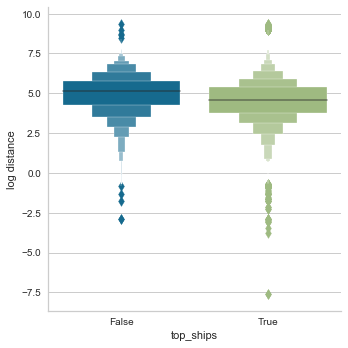

In [239]:
df["top_ships"] = df["vehicle_type"].isin(['sedan', 'suv', '4_door_pickup', 'other', 'van'])
cat_plot = sns.catplot(x="top_ships", y="log distance",
            kind="boxen", dodge=False, data=df);
cat_plot.savefig('top_ships_dist.png')

In [240]:
print('The mean distance of vehicles not in the top five of shipped vehicle types is', np.mean(df.groupby('top_ships')['distance'].mean()[0]))
print('The mean distance of vehicles in the top five of shipped vehicle types is', np.mean(df.groupby('top_ships')['distance'].mean()[1]))

The mean distance of vehicles not in the top five of shipped vehicle types is 281.31058244911173
The mean distance of vehicles in the top five of shipped vehicle types is 198.11402065754618


Interestingly, the mean distances of shipped vehicles is different between top shipped groups. Just for fun, is this statistically significant? 

In [121]:
# Separating dataframe between top_ship and non-top_ship distances:
control = df[df['top_ships']== 0]['distance'] #non top_shipped vehicles 
experimental = df[df['top_ships'] != 0]['distance'] # top_shipped vehicles

In [123]:
result = stats.ttest_ind(experimental, control)

In [124]:
# Courtesy of callRoko's Northwind Project found here: https://github.com/callRoko/Northwind_Project/blob/master/.ipynb_checkpoints/index-checkpoint.ipynb

def ttest_result(result, alpha):
    """after performing a t-test, use the p-value to tell us whether to reject or fail to reject the null hypothesis"""
    if (result[1] > 0.05):
               print(f"Fail to reject null hypothesis.\n Results are not statisitically significant with a p-value ={result[1]}")
    else:
               print(f"Reject the null hypothesis.\n Results are statistically significant with a p-value ={result[1]}")

In [125]:
ttest_result(result, 0.05)

Reject the null hypothesis.
 Results are statistically significant with a p-value =1.5843639482162108e-89


Is it! That's a cool thing to tell SuperDispatch!

## Pickup location and top shipping groups

Now I'm wondering if there's a difference between shipping groups of vehicles and the pickup and drop-off locations of these groups. The least we can do is get some interesting visuals from this data.

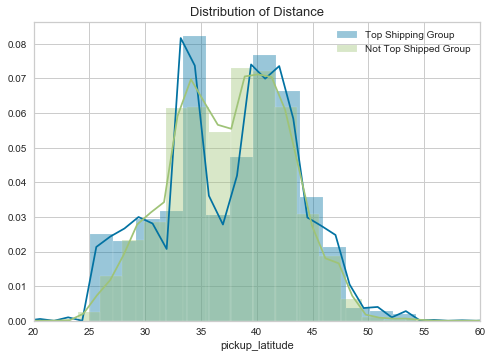

In [147]:
sns.set_style('whitegrid')
control = df[df['top_ships']== 0]['pickup_latitude'] #non top_shipped vehicles 
experimental = df[df['top_ships'] != 0]['pickup_latitude'] # top_shipped vehicles
ax = sns.distplot(experimental, bins = 75, label = 'Top Shipping Group')
ax = sns.distplot(control, bins = 75, label = 'Not Top Shipped Group')
ax.set_xlim(20,60)
ax.set_title('Distribution of Distance', fontsize = 13)
ax.legend()

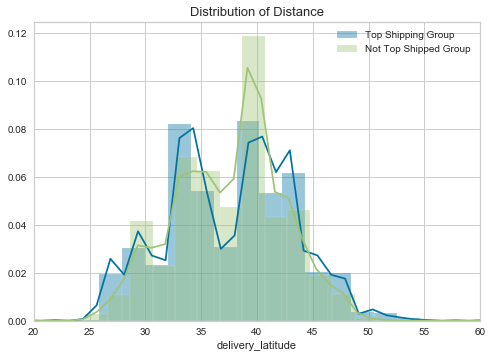

In [146]:
sns.set_style('whitegrid')
control = df[df['top_ships']== 0]['delivery_latitude'] #non top_shipped vehicles 
experimental = df[df['top_ships'] != 0]['delivery_latitude'] # top_shipped vehicles
ax = sns.distplot(experimental, bins = 75, label = 'Top Shipping Group')
ax = sns.distplot(control, bins = 75, label = 'Not Top Shipped Group')
ax.set_xlim(20,60)
ax.set_title('Distribution of Distance', fontsize = 13)
ax.legend()

### Conclusions from Exploring the Data:
- The high density of price range is from 4.4816890703380645 to 148.4131591025766 dollars
- The high density distance range is from 13.463738035001692 to 403.4287934927351 miles
- The mean distance of vehicles not in the top five of shipped vehicle types is 281.31058244911173 miles
- The mean distance of vehicles not in the top five of shipped vehicle types is 198.11402065754618 miles
    - These are statistically significantly different based on a t-test
- More pickups happen in the 35-40 latitude area in the `not top shipped group` as compared to the `top shipped group` of vehicles
- More deliveries happen in the 37.5-40 latitude area in the `not top shipped group` as compared to the `top shipped group` of vehicles

---

<a id="model"></a>
# Step 4: *M*odel the Data

## LabelEncode Vehicle Type

We want our machine learning model in production and in theory to be able to look at `vehicle_type` and "remember the classes that it saw when it was trained, so we will use `sklearn`'s `LabelEncoder`.

In [154]:
X = np.array(df[['vehicle_type']])

In [155]:
X = X.reshape(-1,1)

In [156]:
X = df['vehicle_type']

In [158]:
encoder = LabelEncoder()
encoder.fit(X)
np.save('vehicle_classes.npy', encoder.classes_)

In [159]:
encoder.transform(X)

array([11, 11, 10, ..., 11, 11, 10])

In [160]:
vehicle_cats = df[['vehicle_type']].apply(encoder.fit_transform) # Save the classes in a variable and join them in a dataframe that will be used in training

In [161]:
df = vehicle_cats.join(df[['vehicle_year', 'is_inoperable', 'distance', 'vehicle_price']])

In [168]:
df.head() # Now things look all numbers :-) 

vehicle_type  vehicle_year  is_inoperable   distance  vehicle_price
35            11          2013              0  31.387102           70.0
36            11          2018              0  31.387102           70.0
37            10          2014              0  31.387102           70.0
38            11          2008              0  31.387102           70.0
39            11          2016              0  31.387102           70.0

In [163]:
df['distance'] = df['distance'].astype('float') # Make sure distance is a float

In [165]:
df = df[(df['vehicle_price'] < 25000)] # Let's get rid of outliers very quickly (not the best)

## Build the model

Using linear regression as the supervised learning model, let's look at some of the models we can fit. Here's what we'll look at:
1. Vanilla `LinearRegression` from `sklearn`
2. A RidgeRegressor from `sklearn`
3. Then...for funsies...an ensemble method that has served me well in the past: `RandomForestRegressor`

In [169]:
# Set the X and y
X = df[['vehicle_type', 'distance', 'vehicle_year', 'is_inoperable']] 
y = df['vehicle_price']

In [170]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2,
                                                   random_state = 0)

### Train the LinearRegression Model

In [172]:
lr = LinearRegression()

lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### Train the RidgeRegressor

In [175]:
rr = Ridge(alpha=1.0)

rr.fit(X_train,y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

### Train the RFRegressor

In [176]:
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)

In [177]:
regressor.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

## Test and validate the model

In [178]:
rfr_predictions = regressor.predict(X_test)
rr_predictions = rr.predict(X_test)
lr_predictions = lr.predict(X_test)

In [179]:
# Use MAPE as a way to evaluate the model
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean((y_true - y_pred) / y_true) * 100

In [180]:
y_test = np.array(y_test).reshape(-1,1) # Make y-test similar to how the API will look

In [183]:
rfr_predictions = np.array(rfr_predictions).reshape(-1,1)
rr_predictions = np.array(rr_predictions).reshape(-1,1)
lr_predictions = np.array(lr_predictions).reshape(-1,1)

In [188]:
print('The MAPE of the Random Forest Regressor is', mean_absolute_percentage_error(y_test,rfr_predictions))
print('The MAPE of the Ridge Regressor is', mean_absolute_percentage_error(y_test,rr_predictions))
print('The MAPE of the Vanilla Linear Regressor is', mean_absolute_percentage_error(y_test,lr_predictions))

The MAPE of the Random Forest Regressor is -inf
The MAPE of the Ridge Regressor is -inf
The MAPE of the Vanilla Linear Regressor is -inf


<ipython-input-179-3d519ee7fb15>:4: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean((y_true - y_pred) / y_true) * 100


In [190]:
print('The MAE of the Random Forest Regressor is', mean_absolute_error(y_test,rfr_predictions))
print('The MAE of the Ridge Regressor is', mean_absolute_error(y_test,rr_predictions))
print('The MAE of the Vanilla Linear Regressor is', mean_absolute_error(y_test,lr_predictions))

The MAE of the Random Forest Regressor is 31.09320423189839
The MAE of the Ridge Regressor is 83.60280537299847
The MAE of the Vanilla Linear Regressor is 83.60280546336696


In [208]:
print('The RMSE of the Random Forest Regressor is', mean_squared_error(y_test,rfr_predictions, squared = False))
print('The RMSE of the Ridge Regressor is', mean_squared_error(y_test,rr_predictions, squared = False))
print('The RMSE of the Vanilla Linear Regressor is', mean_squared_error(y_test,lr_predictions, squared = False))

The RMSE of the Random Forest Regressor is 107.1080155411952
The RMSE of the Ridge Regressor is 175.82803036409535
The RMSE of the Vanilla Linear Regressor is 175.8280303773228


In [201]:
error_matrix = y_test - rr_predictions
error_list = error_matrix.tolist()

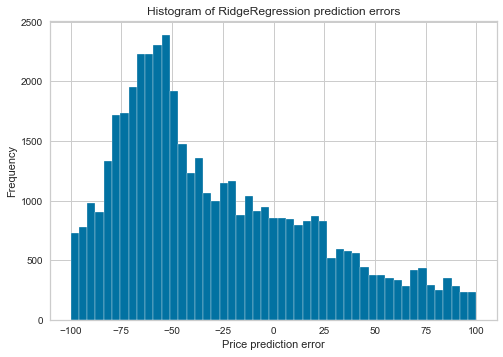

In [202]:
plt.hist(error_matrix, bins = np.linspace(-100,100))
plt.title('Histogram of RidgeRegression prediction errors')
plt.xlabel('Price prediction error')
plt.ylabel('Frequency')
plt.savefig('rr_error_hist.png')

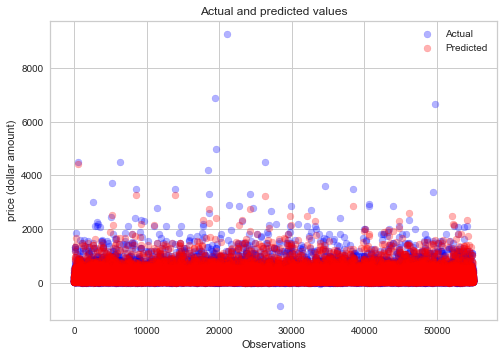

In [206]:
_, ax = plt.subplots()

ax.scatter(x = range(0, y_test.size), y=y_test, c = 'blue', label = 'Actual', alpha = 0.3)
ax.scatter(x = range(0, rfr_predictions.size), y=rfr_predictions, c = 'red', label = 'Predicted', alpha = 0.3)

plt.title('Actual and predicted values')
plt.xlabel('Observations')
plt.ylabel('price (dollar amount)')
plt.legend()
plt.show()

### Conclusions from Modeling the Data:
- The Mean Absolute Error of the models are as follows:
    - The MAE of the Random Forest Regressor is 31.09320423189839
    - The MAE of the Ridge Regressor is 83.60280537299847
    - The MAE of the Vanilla Linear Regressor is 83.60280546336696
- The Root Mean Squared Error of the models are as follows:
    - The RMSE of the Random Forest Regressor is 107.1080155411952
    - The RMSE of the Ridge Regressor is 175.82803036409535
    - The RMSE of the Vanilla Linear Regressor is 175.8280303773228
- **The RF Regressor is the best candidate to move to API baseline, but there is some suggestion that is may be underfit**
---

<a id="interpret"></a>
# Step 5: i*N*terpret the Model (or in our case, put it in production) 

For more of this section, please look at the `/api/ml-eng` dir in this repo.

## Pickle, Package, and (Re)-Test the Model

In [52]:
filename = 'sd_rfreg_file.pkl'
outfile = open(filename,'wb')

pickle.dump(regressor,outfile)
outfile.close()

In [53]:
infile = open(filename,'rb')
regressor = pickle.load(infile)

In [54]:
row = X_test[0:1]

In [55]:
row

vehicle_type  distance  vehicle_year  is_inoperable
1217745            10  32.25197          2002              0

In [56]:
regressor.predict(row)

array([65.])

## Test out some API features : preprocessing JSON data

In [124]:
row = df[0:1].drop(columns = ['pickup_coordinates', 'delivery_coordinates', 'distance', 'vehicle_price'])

In [125]:
row['is_inoperable'] = 'f'

In [126]:
row

pickup_latitude  pickup_longitude  delivery_latitude  delivery_longitude  \
35        26.233345        -80.205093          26.687171          -80.182647   

    vehicle_year vehicle_type is_inoperable  
35          2013          suv             f

In [127]:
row.to_json('sample_row.json')

In [1]:
import json

In [6]:
row = pd.read_json('sample_row.json')

In [9]:
pd.DataFrame(row)

pickup_latitude  pickup_longitude  delivery_latitude  delivery_longitude  \
35        26.233345        -80.205093          26.687171          -80.182647   

    vehicle_year vehicle_type is_inoperable  
35          2013          suv             f

In [173]:
def pairs_coordinates(latitude, longitude):
        return (latitude.iloc[0], longitude.iloc[0]) 

In [174]:
pairs_coordinates(row['pickup_latitude'], row['pickup_longitude'])

(26.233344800000005, -80.2050934)

In [172]:
row['pickup_latitude'].iloc[0]

26.233344800000005

In [179]:
features = df.drop(columns = ['vehicle_price', 'pickup_coordinates', 'delivery_coordinates','distance'], axis = 1).columns
pickle.dump(features, open('features.pkl', 'wb'))

In [180]:
features

Index(['pickup_latitude', 'pickup_longitude', 'delivery_latitude',
       'delivery_longitude', 'vehicle_year', 'vehicle_type', 'is_inoperable'],
      dtype='object')

---

<a id="conclu"></a>
# Conclusions

From our preceding work, we have found that the pre-selection of features really constrains our modeling. However, we were able to find some very interesting business-related conclusions from the data. They are as follows:

1. The list of top 5 most shipped vehicle types is 'sedan', 'suv', '4_door_pickup', 'other', and 'van'. These vehicles are shipped in a range less than all other vehicles. This is almost 100 miles less on average than other vehicles, and it is statistically significant after a student's t-test. Therefore, Kansas City companies should focus their markets on these vehicle types on on trips centering around 200 miles as the mean. 
2. Going back to the the top shipped vehicles, most are picked up or dropped off in the 35-40th parallel (on average), thus Kansas City shipping companies can also augment their markets to look for vehicles shipped to and from Kansas and Nebraska. 
3. The RF Regressor model is currently the best model to put into production to figure out trip price for all vehicle types, but there is worry that it might be underfit.


<a id="future"></a>
# Future Work

The future of this work includes the following bullet points:
- Work towards a better model to put into production on the API. Previously I have tried to do clustering on the types of trips that may exist in the data, but with no luck, so I will look at other ensemble models to test. One that seems particularly interesting, if I can get the computer power to work is [mlxtend's StackingRegressor](https://rasbt.github.io/mlxtend/user_guide/regressor/StackingRegressor/).
- The API is being continuously monitored for speed and accuracy. I want to make sure that the permutations of a call can be achieved. Something similar to:
<code>{"pickup_latitude": 36.130518, "pickup_longitude": -115.085227, "delivery_latitude": 41.845691, "delivery_longitude": -87.678616, "vehicle_year": 2015, "vehicle_type": "sedan", "is_inoperable": true}</code>
    - ** The API would return all the permutations of `is_inoperable` and `vehicle_type`: **
        <br><code>{"predictions": [ {"vehicle_type": "suv", "is_inoperable": true, "prediction": 929.15},
        {"vehicle_type": "suv","is_inoperable": false,"prediction": 929.15},
        {"vehicle_type": "sedan","is_inoperable": true,"prediction": 929.15},
        {"vehicle_type": "sedan","is_inoperable": false, "prediction": 929.15},</code>